(data_preparation)=

# Datenvorbereitung

```{admonition} Erklärung zum Prozessschritt (Aufklappen)
:class: dropdown
Diese Phase ist oftmals der aufwendigste Teil im gesamten Projekt, da Daten verschiedenartig sein können und es immer eine individuelle Aufgabe ist. Dieser Bearbeitungsschritt inkludiert alle Aktivitäten die zur Erstellung der finalen Datensätze benötigt werden. Dies schließt die Datenauswahl, die Bearbeitung sowie die Bereinigung und Transformation der Rohdaten mit ein. Rohdaten sind hierbei jene Form von Daten die von den Unternehmen, ungefiltert und ungeändert zur Verfügung gestellt werden. Je nach Grad der Datenqualität ist eine hohe oder nur geringfügige Datenbereinigung erforderlich. Jedoch kommt kein Projekt ohne Datentransformationen aus. Oftmals liegen die Daten in einem ungünstigen Format vor und müssen erst ordentlich kodiert und formatiert werden. Beispielsweise könnten falsche Datentypen zu Problemen bei der Analyse führen bis hin zu nicht ausführbaren Modellen. Manchmal müssen sogar künstlich neue Daten erzeugt werden, wenn die vorhandenen Datenbestände zu geringfügig sind. Daher ist es wichtig diese Phase mit Sorgfalt zu durchlaufen. Folgende Kernprozesse fallen also häufig an:

* Datenauswahl und Festlegung der Granularität
* Bereinigung und Transformation der Daten
* Formatierung und Integration der Daten

Auch an dieser Stelle bieten wir ihnen umfangreiche Möglichkeiten an ihre Daten zu verarbeiten und auszuwerten. Am KI-Kompetenzzentrum der THU stehen ausreichend große Speicherkapazitäten zur Verfügung um sogar große Datenmengen zu verarbeiten.
```

```{admonition} Handwerkerbewertungen:
:class: tip
Bezogen auf den exemplifizierten Anwendungsfall können wir die Texte von den Handwerksbewertungen auf Unvollständigkeit, Satzzeichen, Umlaute oder Worthäufigkeiten näher untersuchen. Hierzu sollten wir aber erst die Texte in einzelne Wörter (sog. Tokens) unterteilen. Außerdem ist es sinnvoll die Wortverschiedenheit zu verringern. Hier könnten wir beispielsweise die Texte alle in Kleinschreibung formatieren und Standardwörter wie Personalpronomen oder Satzzeichen entfernen. Denn aus der Problembeschreibung wissen wir, dass es nicht relevant ist, ob der Text groß oder klein geschrieben ist. Wir wollen nur die Gefühlslage des Kunden einschätzen. 
```

#### Textvorverarbeitung

Entfernen wir zunächst jene Bewertungen die weniger als 4 Wörter enthalten. Anschließend splitten wir die Texte in einzelne Tokens auf und bereinigen diese.

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
from sentimental_imports import *

df = pd.read_csv("bewertungen_roh.csv")
df = df[~df["Anzahl Wörter"].isin([1,2,3,4])]

# Entfernung von irrelevanten Wörtern, Interpunkten und Splitten in Tokens
german_stop_words = stopwords.words('german')
def textvorverarbeitung(text):
    text_tokens = [word.lower() for word in word_tokenize(text) if word.isalpha()]
    return [word for word in text_tokens if not word in german_stop_words]

df["Token"] = df.apply(lambda x: textvorverarbeitung(x.Bewertungstext), axis=1)
print(f'Vor der Datenbereinigung: {df.loc[10, "Bewertungstext"]}')
print(f'Nach der Datenbereinigung: {textvorverarbeitung(df.loc[10, "Bewertungstext"])}')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pascal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Vor der Datenbereinigung: Schnell einfach hat mir sehr geholfen."Ausgezeichnetes Fachwissen " 
Nach der Datenbereinigung: ['schnell', 'einfach', 'geholfen', 'ausgezeichnetes', 'fachwissen']


Wie zu sehen ist, haben wir die inhaltliche Aussage der Bewertung trotz Reduktion der Wörter nicht entfernt. Stattdessen haben wir nun durch die Vorverarbeitung geeignete Eingabedaten für die Modellentwicklung geliefert. Dadurch können wir uns z.B. anschauen, welche Wörter denn am häufigsten in den Bewertungen verwendet wurden.

In [2]:
results = Counter()
df.Token.apply(lambda x: ' '.join(x)).str.split(" ").apply(results.update)
list(results.most_common())[:10]

[('firma', 8687),
 ('wurde', 7420),
 ('immer', 4766),
 ('empfehlen', 4714),
 ('arbeit', 4519),
 ('super', 3907),
 ('beratung', 3731),
 ('schnell', 3567),
 ('freundlich', 3459),
 ('gute', 3414)]

Text(0, 0.5, 'Worthäufigkeit')

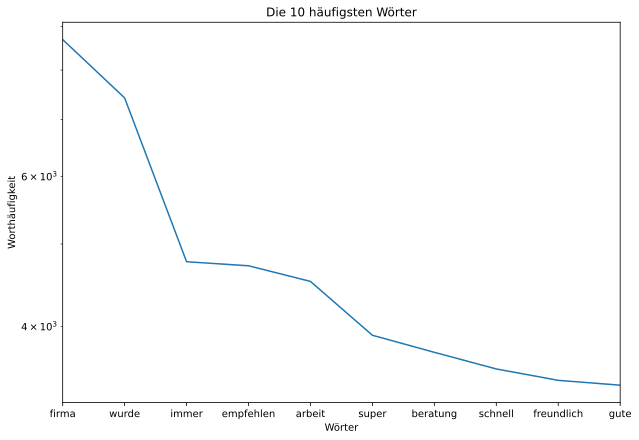

In [3]:
MAX_LENGTH = 10
words_common = [word for word in [k for k in dict(results.most_common()).keys()][:MAX_LENGTH] if not word in stopwords.words()]
words_common = [re.sub('[^A-Za-z0-9]+', ' ', k) for k in words_common]
plt.figure(figsize=(10, 7))
y_values = [results[key] for key in words_common][:MAX_LENGTH]
x_values = words_common[:MAX_LENGTH]
plt.plot(x_values, y_values)
plt.title(f"Die {MAX_LENGTH} häufigsten Wörter")
plt.xlabel("Wörter")
plt.yscale("log")
plt.xlim([0, MAX_LENGTH-1])
plt.ylabel("Worthäufigkeit")

Es dürfte wenig überraschend sein, dass am häufigsten das Wort Firma im Textkorpus auftaucht, gefolgt von Standardwörtern wie wurde und immer. Interessant ist hier das Zusammenspiel zur Häufigkeit der 5 Sternebewertungen. In Phase 1 haben wir beobachtet, dass auffallend viele positive Bewertungen vorhanden sind. Dies deckt sich auch mit dem Schaubild oben. Die Wörter dort würde man eher positiven Bewertungen zuordnen. Wir können uns auch beispielsweise Wortwolken darstellen lassen:

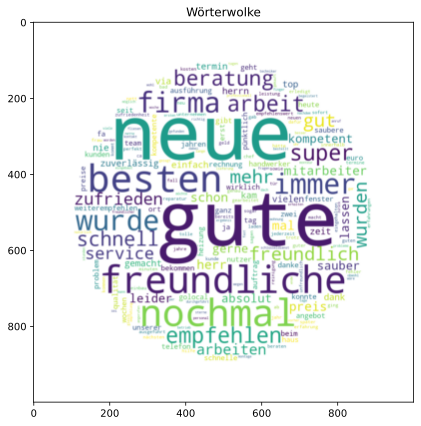

In [4]:
# Wörterwolke
x, y = np.ogrid[:1000, :1000]
mask = (x - 500) ** 2 + (y - 500) ** 2 > 400 ** 2
mask = 255 * mask.astype(int)
wordcloud = WordCloud(background_color="white", mask=mask).generate(' '.join([word for word in [k for k in dict(results.most_common()).keys()][:MAX_LENGTH + 450]]))
plt.figure(figsize=(10, 7))
plt.title("Wörterwolke")
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()

In [5]:
# Speichern wir noch unsere aufbereiteten Daten ab
df.to_csv("bewertungen_aufbereitet.csv", index=False)

Man könnte als nächstes noch eine weitere Wortreduktion betreiben und beispielsweise mit einer benutzerdefinierten Wortliste jene Wörter entfernen, 
die keinen Mehrwert haben. Denkbar wäre es auch die Wörter in ihrer Grundform zu überführen. So kann aus der Wortwolke gesehen werden, 
dass es einmal *wurde* und einmal *wurden* gibt. Beides hat semantisch die gleiche Bedeutung. 
Wie auch immer, für den demonstrativen Anwendungsfall können wir an dieser Stelle zur nächsten Phase, der Modellierung springen.

```{exercise} Ihre Aufgaben
:class: dropdown
:nonumber: true
* Oben wurden die $10$ häufigsten Wörter betrachtet. Adaptieren Sie den Python Code und zeigen Sie die $10$ seltensten Wörter an.
* Es wurden sogenannte *Stopwörter* entfernt. Was ist darunter zu verstehen? Finden Sie mindestens $20$ verschiedene Stoppwörter aus dem Textkorpus der Handwerkerbewertungen.
* Das Problem mit *wurde* und *wurden* besteht leider immer noch. Wie können Sie in Python das Problem lösen? Zeigen Sie Ihren Lösungsweg anhand der Bewertungstexte.

**Hinweis:** Eventuell hilft Ihnen der Begriff [**Stemming**](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html) weiter.
```